# Popularity Based Recommender System

In [1]:
import os
import pandas as pd
import configparser
#import mysql.connector
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

config = configparser.ConfigParser()
config.read('..\\config.ini')

host = config['mysql']['host']
database = config['mysql']['database']
user = config['mysql']['user']
password = config['mysql']['password']
port = config['mysql']['port']

def read_query(query):
    engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')
    df = pd.read_sql(query, con=engine)
    print('Query Executed!')
    return df

Finding the most Popular item on weekday and weekend respectively:

To 5 items for a weekday:

In [4]:
q = """
SELECT 
    article_id, MAX(total_purchases) AS most_popular
FROM
    popularity_v1
WHERE
    day_type = 'weekday'
GROUP BY article_id
ORDER BY most_popular DESC
LIMIT 5;
"""

read_query(q)

Query Executed!


,article_id,most_popular
0,706016001,30423.0
1,706016002,20513.0
2,706016003,14290.0
3,448509014,13496.0
4,562245001,12826.0


To 5 items for a weekend:

In [5]:
q = """
SELECT 
    article_id, MAX(total_purchases) AS most_popular
FROM
    popularity_v1
WHERE
    day_type = 'weekend'
GROUP BY article_id
ORDER BY most_popular DESC
LIMIT 5;
"""

read_query(q)

Query Executed!


,article_id,most_popular
0,706016001,12121.0
1,706016002,8779.0
2,562245001,6636.0
3,706016003,5591.0
4,351484002,5392.0


We will first build out the recommender system that recoomends the top 5 most popular items based on if the day is a weekday or weekend by using the most_popular items for that day in the past.

In [8]:
day = 'weekend'

if day == "weekday":
    q = """
    SELECT 
        article_id, MAX(total_purchases) AS most_popular
    FROM
        popularity_v1
    WHERE
        day_type = 'weekday'
    GROUP BY article_id
    ORDER BY most_popular DESC
    LIMIT 5;
    """
else:
    q = """
    SELECT 
    article_id, MAX(total_purchases) AS most_popular
    FROM
        popularity_v1
    WHERE
        day_type = 'weekend'
    GROUP BY article_id
    ORDER BY most_popular DESC
    LIMIT 5;
    """

result = read_query(q)

result

Query Executed!


,article_id,most_popular
0,706016001,12121.0
1,706016002,8779.0
2,562245001,6636.0
3,706016003,5591.0
4,351484002,5392.0


In [16]:
import matplotlib.image as mpimg

Once we have the top 5 products we will use the article_id to retireve the image of the product:

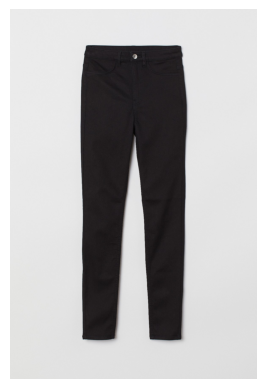

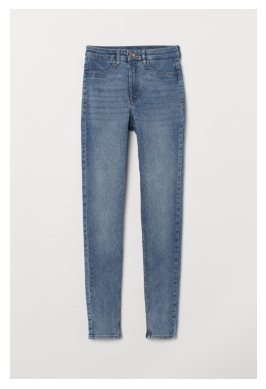

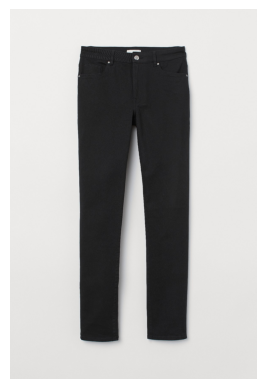

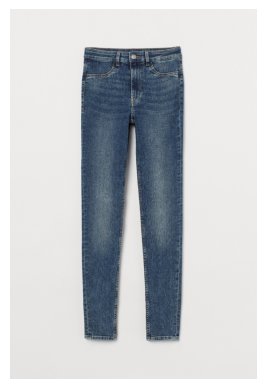

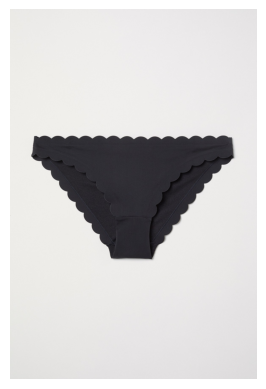

In [20]:
location_of_subfolders = "..//h-and-m-personalized-fashion-recommendations//images"


all_articles = []

for i in result['article_id']:
    # get first 2 letters of the name and get subfolder name:
    folder_name = '0' + i[:2]

    location_of_images = os.path.join(location_of_subfolders, folder_name)
    image_names = '0' + i + '.jpg'
    image_location = os.path.join(location_of_images, image_names)

    # Load the image from image location
    img = mpimg.imread(image_location)

    plt.imshow(img)
    plt.axis('off')
    plt.show()


Saving all ina function:

In [21]:
def dispaly_images(article_list):
    """
        article_list is a list of all the ids of the articles we want to retrieve
    """
    # Subfolder containing the images
    location_of_subfolders = "..//h-and-m-personalized-fashion-recommendations//images"

    for i in article_list:
        # get first 2 letters of the name and get subfolder name:
        folder_name = '0' + i[:2]

        location_of_images = os.path.join(location_of_subfolders, folder_name)
        image_names = '0' + i + '.jpg'
        image_location = os.path.join(location_of_images, image_names)

        # Load the image from image location
        img = mpimg.imread(image_location)

        plt.imshow(img)
        plt.axis('off')
        plt.show()

From looking at the results one issue we can notice is that the top 4 results are all jeans and they seem to all look the same! So instead of showing just jeans as recommended products, we can get more information about each product and then group them so that we get some more variety.

In `articles_EDA` notebook we already explored the features available for each product so we can now get the relevant features for each product here:

In [22]:
q = """
SELECT 
    P.article_id,
    P.total_purchases,
    P.day_type,
    A.prod_name,
    A.product_type_name,
    A.product_group_name,
    A.department_name,
    A.section_name,
    A.garment_group_name,
    A.index_group_name
FROM
    popularity_v1 P,
    articles A
WHERE
    P.article_id = A.article_id;
"""

read_query(q)

Query Executed!


,article_id,total_purchases,day_type,prod_name,product_type_name,product_group_name,department_name,section_name,garment_group_name,index_group_name
0,211143037,366.0,weekday,Janet SL-set (W),Pyjama set,Nightwear,Nightwear,"Womens Nightwear, Socks & Tigh","Under-, Nightwear",Ladieswear
1,255396006,77.0,weekday,Nora Cardigan,Cardigan,Garment Upper body,Jersey Fancy DS,Divided Selected,Jersey Fancy,Divided
2,294008002,2809.0,weekday,HM+ Cora tee,Costumes,Garment Full body,Jersey,H&M+,Jersey Fancy,Ladieswear
3,176550020,40.0,weekday,Sleep bag padded,Sleep Bag,Underwear/nightwear,Baby Nightwear,Baby Essentials & Complements,"Under-, Nightwear",Baby/Children
4,212629040,305.0,weekday,Alcazar strap dress,Dress,Garment Full body,Basic 1,Divided Basics,Jersey Basic,Divided
...,...,...,...,...,...,...,...,...,...,...
185097,850795002,4.0,weekday,Sun skirt,Skirt,Garment Lower body,Kids Girl Dresses,Kids Girl,Dresses/Skirts girls,Baby/Children
185098,910439003,7.0,weekday,Petit Madison HW denim,Trousers,Garment Lower body,Trouser,Womens Everyday Collection,Trousers,Ladieswear
185099,903950001,7.0,weekday,Riga trousers,Trousers,Garment Lower body,Loungewear,"Womens Nightwear, Socks & Tigh","Under-, Nightwear",Ladieswear
185100,880553004,4.0,weekday,OP NEW Perth Push,Unknown,Unknown,Clean Lingerie,Womens Lingerie,"Under-, Nightwear",Ladieswear
